In [1]:
from spreco.common import utils

import os
import numpy as np

#result_path = '/home/gluo/workspace/nlinv_prior/results/mprage/redu'
#exprs       = ['2', '3']
result_path = '/home/ague/archive/projects/2023/gluo/learned_reg'
exprs       = ['redu_3_5_5_2', 'redu_3_5_5_3']
recos_1     = ['l2_pics_volume', 'l1_pics_volume', 'abide_pics_volume', 'abide_f_pics_volume',
               'hku_pics_volume']
recos_2     = ['l2_nlinv_volume', 'l1_nlinv_volume', 'abide_nlinv_volume', 'abide_f_nlinv_volume',
               'hku_nlinv_volume']

2023-02-27 09:15:19.251068: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
normalize = lambda x: abs(x)/np.linalg.norm(abs(x))
readcfl   = lambda dir, file: utils.readcfl(os.path.join(dir, file))
win_ftr   = 0.65
saveimg   = lambda x, upper, name: utils.save_img(x, "./sub_figs/"+name, vmax=upper*win_ftr)
slice     = 40  # slice to be printed
shift     = 70

def compute_stats(exprs, recos, refs, sens='coils', logging=False):

    if logging:
        print('pattern & ', end='')
        for i, reco in enumerate(recos):
            print(reco, end='')
            if i != len(recos)-1:
                print(' & ', end='')
            else: 
                print('\n', end='')
    
    if logging:
        print('%---------PSNR-----------')

    stats={}
    for expr in exprs:

        cur_dir     = os.path.join(result_path, expr)
        coils       = readcfl(cur_dir, sens)

        if logging:
            upper       = np.max(normalize(grd[:,:,slice]))
            saveimg(normalize(grd[:,:,slice]), upper, 'ref')
            print('%s\t&\t'%expr, end='')

        psnrs=[ []for _ in range(len(recos))]
        for i, reco in enumerate(recos):
            grd = readcfl(cur_dir, refs[i])
            img = readcfl(cur_dir, reco)
            for j in range(grd.shape[-1]):
                mask = np.squeeze(coils[:,:,j+shift,0]>0.000001)
                a    = normalize(grd[..., j]*mask)
                b    = normalize(img[..., j]*mask)
                psnrs[i].append(utils.psnr(a, b))

            if logging:
                saveimg(normalize(img[:,:,slice]), upper, expr+'_'+reco)
                print("%.2f"%np.mean(psnrs[i]), end='')

                if i != len(recos)-1:
                    print('\t&\t', end='')
                else:
                    print('\n', end='')
        stats[expr+'_psnrs']=psnrs

    if logging:
        print('%---------SSIM-----------')

    for expr in exprs:

        cur_dir     = os.path.join(result_path, expr)
        coils       = readcfl(cur_dir, sens)

        ssims=[ []for _ in range(len(recos))]

        if logging:
            print('%s\t&\t'%expr, end='')

        for i, reco in enumerate(recos):
            img = readcfl(cur_dir, reco)
            grd = readcfl(cur_dir, refs[i])
            for j in range(grd.shape[-1]):
                mask = np.squeeze(coils[:,:,j+shift,0]>0.0000001)
                a    = normalize(grd[..., j]*mask)
                b    = normalize(img[..., j]*mask)
                ssims[i].append(utils.ssim(a, b))
            
            if logging:
                print("%.4f"%np.mean(ssims[i]), end='')

                if i != len(recos)-1:
                    print('\t&\t', end='')
                else:
                    print('\n', end='')
        stats[expr+'_ssims']=ssims
    return stats

In [3]:
import tikzplotlib
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 2 #set the value globally
import matplotlib.pyplot as plt
%matplotlib inline

def plot_curves(ax, key, labels, stats, title, xlabel, ylabel):
    
    for i, reco in enumerate(labels):
        if i<5:
            line=ax.plot(stats[key][i], label=reco[:-7])
        else:
            line=ax.plot(stats[key][i], "-.", label=reco[:-7])
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [4]:
import matplotlib.patches as mpatches
def boxplot(ax, stats, key, title, recos, legends, ylabel, ylim):
    factor=2
    space=0.25
    bpl=ax.boxplot(stats[0][key], positions=np.array(range(len(stats[0][key])))*factor-space)
    bpr=ax.boxplot(stats[1][key], positions=np.array(range(len(stats[0][key])))*factor+space)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
        
    ax.set_xticks(np.arange(0, len(recos) * factor, factor))
    ax.set_xticklabels(recos)
    
    ax.set_ylim(ylim)

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')

    if legends[0] != '':
        ax.plot([0], c='#D7191C', label=legends[0])
        ax.plot([0], c='#2C7BB6', label=legends[1])
        #leg = ax.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.2), frameon=False, shadow=False,framealpha=0)
        #for line in leg.get_lines():
            #line.set_linewidth(4.0)
        red_patch1 = mpatches.Patch(edgecolor='#D7191C',fill=False, label=legends[0])
        red_patch2 = mpatches.Patch(edgecolor='#2C7BB6',fill=False, label=legends[1])
        ax.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.25), handles=[red_patch1, red_patch2],frameon=False, shadow=False,framealpha=0)
    ax.grid("on")



# Evaluation 1

1. L1 reconstruction of 2 times undersampled k-space is used as reference for L1 reconstruction of 4 and 6 times undersampled k-space in the case of using PICS, and likewise for the case of using NLINV

In [6]:
refs1 =['../redu_3_5_5_1/l1_pics_volume' for _ in range(len(recos_1))]
refs2 =['../redu_3_5_5_1/l1_nlinv_volume' for _ in range(len(recos_1))]
pics_stats = compute_stats(exprs, recos_1, refs1, logging=False)
nlinv_stats = compute_stats(exprs, recos_2, refs2, logging=False)

### boxplot to evaluate the priors as image regularization when reconstructing image using PICS and NLINV

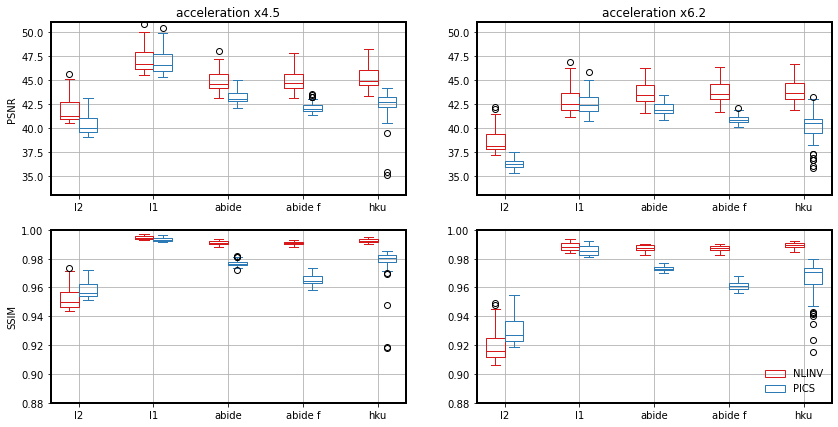

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(14, 7))
boxplot(axs[0][0], [nlinv_stats, pics_stats], exprs[0]+'_psnrs', 'acceleration x4.5', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['', ''],'PSNR', ylim=[33,51])
boxplot(axs[0][1], [nlinv_stats, pics_stats], exprs[1]+'_psnrs', 'acceleration x6.2', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['', ''],'', ylim=[33,51])
boxplot(axs[1][0], [nlinv_stats, pics_stats], exprs[0]+'_ssims', '', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['', ''],'SSIM', ylim=[0.88,1])
boxplot(axs[1][1], [nlinv_stats, pics_stats], exprs[1]+'_ssims', '', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['NLINV', 'PICS'],'', ylim=[0.88,1])
tikzplotlib.save("./boxplot/stats.tex")
plt.show()

### curve plots of all reconstruction

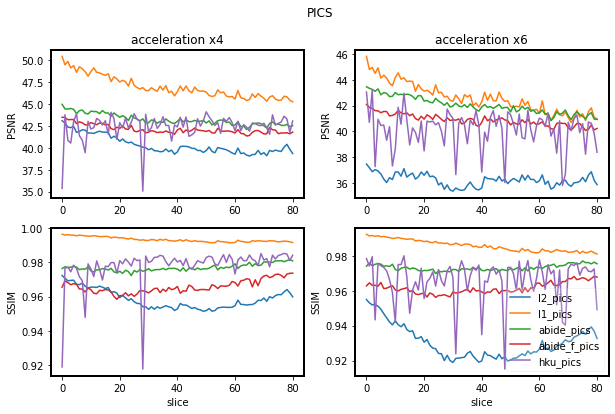

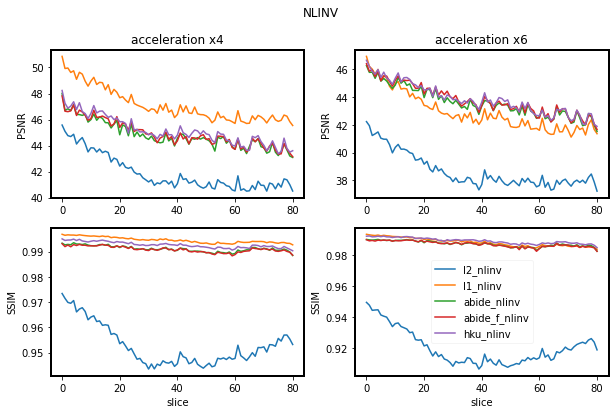

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
plot_curves(axs[0][0], exprs[0]+'_psnrs', recos_1, pics_stats, title='acceleration x4', xlabel='', ylabel='PSNR')
plot_curves(axs[0][1], exprs[1]+'_psnrs', recos_1, pics_stats, title='acceleration x6', xlabel='', ylabel='PSNR')
plot_curves(axs[1][0], exprs[0]+'_ssims', recos_1, pics_stats, title='', xlabel='slice', ylabel='SSIM')
plot_curves(axs[1][1], exprs[1]+'_ssims', recos_1, pics_stats, title='', xlabel='slice', ylabel='SSIM')
plt.suptitle("PICS")
plt.legend(loc='best', fancybox=True, framealpha=0.2)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
plot_curves(axs[0][0], exprs[0]+'_psnrs', recos_2, nlinv_stats, xlabel='', title='acceleration x4', ylabel='PSNR')
plot_curves(axs[0][1], exprs[1]+'_psnrs', recos_2, nlinv_stats, xlabel='', title='acceleration x6', ylabel='PSNR')
plot_curves(axs[1][0], exprs[0]+'_ssims', recos_2, nlinv_stats, title='', xlabel='slice', ylabel='SSIM')
plot_curves(axs[1][1], exprs[1]+'_ssims', recos_2, nlinv_stats, title='', xlabel='slice', ylabel='SSIM')
plt.suptitle("NLINV")
plt.legend(loc='best', fancybox=True, framealpha=0.2)



# Evaluation 2

1. Reconstruction using abide as image regularization of 2 times undersampled k-space is used as reference for L1 reconstruction of 4 and 6 times undersampled k-space in the case of using PICS, and likewise for the case of using NLINV.

In [9]:
refs1 = ['../redu_3_5_5_1/abide_pics_volume' for _ in range(len(recos_1))]
refs2 = ['../redu_3_5_5_1/abide_nlinv_volume' for _ in range(len(recos_1))]
pics_stats = compute_stats(exprs, recos_1, refs1, logging=False)
nlinv_stats = compute_stats(exprs, recos_2, refs2, logging=False)

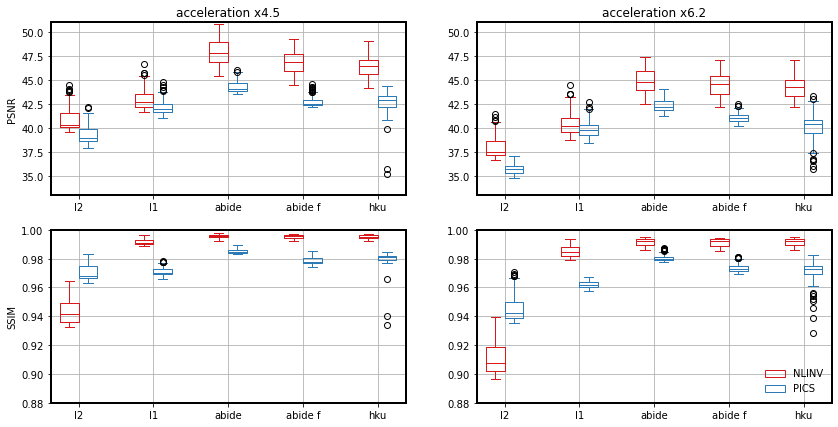

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(14, 7))
boxplot(axs[0][0], [nlinv_stats, pics_stats], exprs[0]+'_psnrs', 'acceleration x4.5', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['', ''],'PSNR', ylim=[33,51])
boxplot(axs[0][1], [nlinv_stats, pics_stats], exprs[1]+'_psnrs', 'acceleration x6.2', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['', ''],'', ylim=[33,51])
boxplot(axs[1][0], [nlinv_stats, pics_stats], exprs[0]+'_ssims', '', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['', ''],'SSIM', ylim=[0.88,1])
boxplot(axs[1][1], [nlinv_stats, pics_stats], exprs[1]+'_ssims', '', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['NLINV', 'PICS'],'', ylim=[0.88,1])
tikzplotlib.save("./boxplot/stats.tex")
plt.show()

### curve plots of all reconstruction

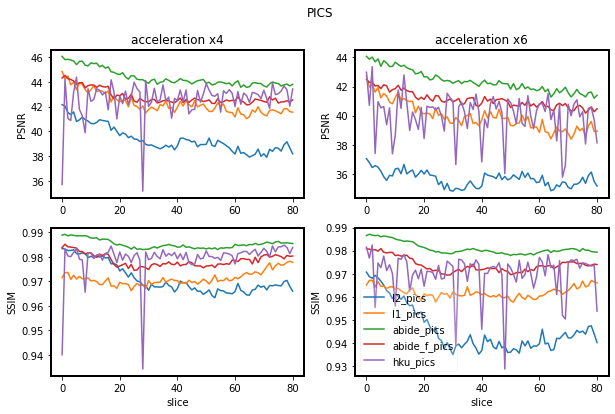

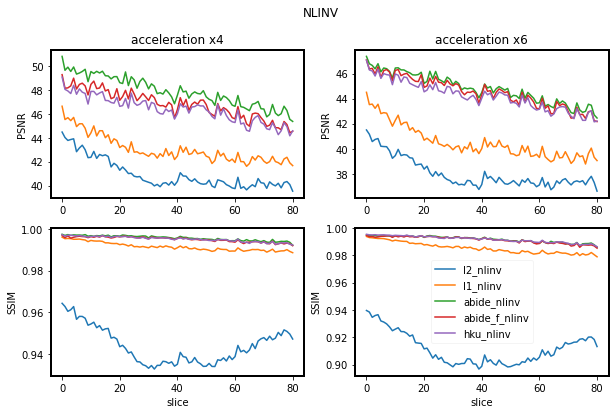

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
plot_curves(axs[0][0], exprs[0]+'_psnrs', recos_1, pics_stats, title='acceleration x4', xlabel='', ylabel='PSNR')
plot_curves(axs[0][1], exprs[1]+'_psnrs', recos_1, pics_stats, title='acceleration x6', xlabel='', ylabel='PSNR')
plot_curves(axs[1][0], exprs[0]+'_ssims', recos_1, pics_stats, title='', xlabel='slice', ylabel='SSIM')
plot_curves(axs[1][1], exprs[1]+'_ssims', recos_1, pics_stats, title='', xlabel='slice', ylabel='SSIM')
plt.suptitle("PICS")
plt.legend(loc='best', fancybox=True, framealpha=0.2)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
plot_curves(axs[0][0], exprs[0]+'_psnrs', recos_2, nlinv_stats, title='acceleration x4', xlabel='', ylabel='PSNR')
plot_curves(axs[0][1], exprs[1]+'_psnrs', recos_2, nlinv_stats, title='acceleration x6', xlabel='', ylabel='PSNR')
plot_curves(axs[1][0], exprs[0]+'_ssims', recos_2, nlinv_stats, title='', xlabel='slice', ylabel='SSIM')
plot_curves(axs[1][1], exprs[1]+'_ssims', recos_2, nlinv_stats, title='', xlabel='slice', ylabel='SSIM')
plt.suptitle("NLINV")
plt.legend(loc='best', fancybox=True, framealpha=0.2)



# Evaluation 3

1. Reconstruction from 2 times undersampled k-space using abide as image regularization is used as reference for L1 reconstruction from 4 and 6 undersampled k-space using abide as image regularization in the case of using PICS, and likewise for the other priors as regularization. And likewise for the case of using NLINV

In [12]:
refs1 = ['../redu_3_5_5_1/l2_pics_volume', '../redu_3_5_5_1/l1_pics_volume', '../redu_3_5_5_1/abide_pics_volume', '../redu_3_5_5_1/abide_f_pics_volume', '../redu_3_5_5_1/hku_pics_volume']
refs2 = ['../redu_3_5_5_1/l2_nlinv_volume', '../redu_3_5_5_1/l1_nlinv_volume', '../redu_3_5_5_1/abide_nlinv_volume', '../redu_3_5_5_1/abide_f_nlinv_volume', '../redu_3_5_5_1/hku_nlinv_volume']
pics_stats = compute_stats(exprs, recos_1, refs1, logging=False)
nlinv_stats = compute_stats(exprs, recos_2, refs2, logging=False)

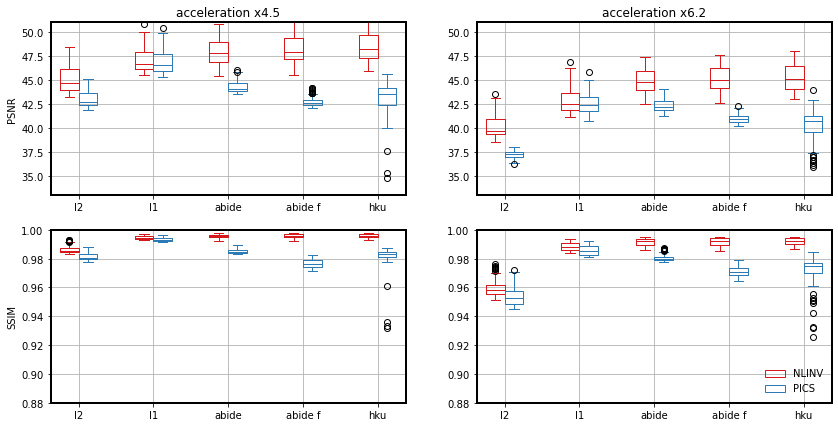

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(14, 7))
boxplot(axs[0][0], [nlinv_stats, pics_stats], exprs[0]+'_psnrs', 'acceleration x4.5', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['', ''],'PSNR', ylim=[33,51])
boxplot(axs[0][1], [nlinv_stats, pics_stats], exprs[1]+'_psnrs', 'acceleration x6.2', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['', ''],'', ylim=[33,51])
boxplot(axs[1][0], [nlinv_stats, pics_stats], exprs[0]+'_ssims', '', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['', ''],'SSIM', ylim=[0.88,1])
boxplot(axs[1][1], [nlinv_stats, pics_stats], exprs[1]+'_ssims', '', ['l2', 'l1', 'abide', 'abide f', 'hku'], ['NLINV', 'PICS'],'', ylim=[0.88,1])
tikzplotlib.save("./boxplot/stats.tex")
plt.show()

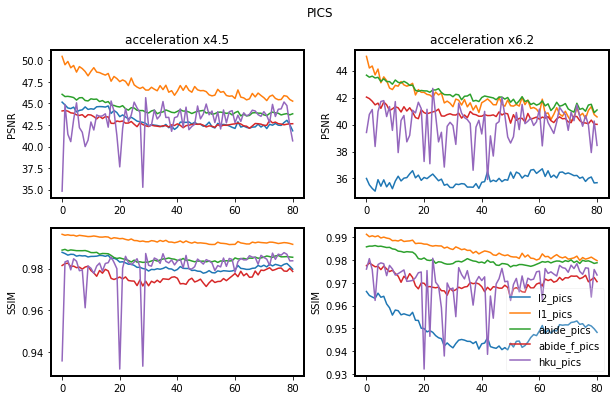

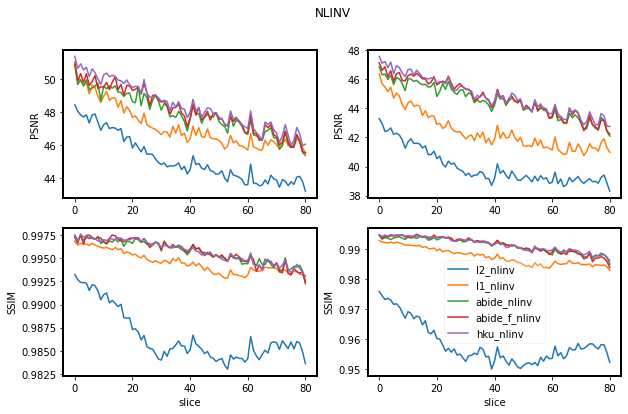

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
plot_curves(axs[0][0], exprs[0]+'_psnrs', recos_1, pics_stats, title='acceleration x4', xlabel='', ylabel='PSNR')
plot_curves(axs[0][1], exprs[1]+'_psnrs', recos_1, pics_stats, title='acceleration x6', xlabel='', ylabel='PSNR')
plot_curves(axs[1][0], exprs[0]+'_ssims', recos_1, pics_stats, title='', xlabel='', ylabel='SSIM')
plot_curves(axs[1][1], exprs[1]+'_ssims', recos_1, pics_stats, title='', xlabel='', ylabel='SSIM')
plt.suptitle("PICS")
plt.legend(loc='best', fancybox=True, framealpha=0.2)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
plot_curves(axs[0][0], exprs[0]+'_psnrs', recos_2, nlinv_stats, title='acceleration x4', xlabel='', ylabel='PSNR')
plot_curves(axs[0][1], exprs[1]+'_psnrs', recos_2, nlinv_stats, title='acceleration x6', xlabel='', ylabel='PSNR')
plot_curves(axs[1][0], exprs[0]+'_ssims', recos_2, nlinv_stats, title='', xlabel='slice', ylabel='SSIM')
plot_curves(axs[1][1], exprs[1]+'_ssims', recos_2, nlinv_stats, title='', xlabel='slice', ylabel='SSIM')
plt.suptitle("NLINV")
plt.legend(loc='best', fancybox=True, framealpha=0.2)